# Introduction

The major weakness of interpreted languages such as python is its speed.
Numba translates python functions into optimized machine code, achieving  speeds
close to compiled C, java, or Fortran. We will begin with converting a simple
function into numba and record the speedup. You will then be responsible for 
converting a non-linear convection code to Numba and report tbe speedup.

# Numba basics

Compilers convert human. readable code (like you write in python) to optimized machine code.
The way compilers work is beyond the scope of this lab but here is analogy. You want to go from your
home to the grocery store and pickup 10 items tommrow.  You can think of this as two functions *goToStore(storeLoc,meansOfTransport)* and
*getItems(listofItems)* The compiled language approach is you know the traffic at the time you will leave, 
choose the best route and best means of transport, and think of the best way through the store to get all your 
items for tomorrow's trip.  Your pre-plan this route.  The equivalent interpreted language approach is you choose your means of transport, start heading to the store. Every X meters you stop, reevaluate your means of transport, and go X meters. Once at the store you get the items in the order they are listed. Obviously the compiled approach will be much faster.

With the introduction of java a third paradigm was introduced, Just-In-Time (JIT) compiling. Continuing the analogy, when you are about to head to the store you pick the best path based on information and go the store. Once you go to the store you calculate the best way through given your items.  This will be slightly slower than the compiled approach on the day of the trip because you have the time it takes to decide the path to the store, and through the store, but it will be significantly faster than the X meter approach.

To demonstrate how to use Numba lets imagine you want to calculate the statistics of a bunch of numbers. We are going to approach this problem in three different ways. Using lists, using numpy arrays, and then using numpy arrays with numba.

We will begin by creating an array of enough numbers that our times will be meaningful.


In [1]:
%%time
import numpy
sz=100000000
randomFloat=numpy.random.uniform(-1,1,sz)
randomList=randomFloat.tolist()

CPU times: user 3.33 s, sys: 1.15 s, total: 4.47 s
Wall time: 4.63 s


We will then define a simple function that calculates the min, max, and average.

In [7]:
def calcStats(list,nsz):
    mn=list[0]
    mx=list[0]
    sm=0
    for i in range(nsz):
        if mn > list[i]:
            mn=list[i]
        if mx < list[i]:
            mx=list[i]
        sm=sm+list[i]
    return mn, mx, sm/nsz

In [8]:
import numba
@numba.jit(nopython=True)
def calcStatsN(list,nsz):
 
    mn=float(list[0])
    mx=float(list[0])
    sm=0.0
    for i in range(nsz):
        if mn > list[i]:
            mn=list[i]
        if mx < list[i]:
            mx=list[i]
        sm=sm+list[i]
    return mn, mx, sm/nsz

We will use cell magics to calculate the time to calculate the statistics on the list.

In [9]:
%%time
print(calcStats(randomList,sz))

(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
CPU times: user 14.1 s, sys: 121 ms, total: 14.2 s
Wall time: 14.3 s


We can use the same function on the numpy array.

In [10]:
%%time
print(calcStats(randomFloat,sz))

(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
CPU times: user 55.6 s, sys: 114 ms, total: 55.7 s
Wall time: 55.8 s


The result might be surprising, and disturbing. The numpy array was not significantly faster and maybe significantly slower. Numpy is useful mainly because most of its functions are really written in compiled languages to gain speed.

Now if we time the numba version of the function...

In [15]:
%%time
for i in range(10):
    print(calcStatsN(randomFloat,sz))

(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
(-0.9999999983045678, 0.9999999805567168, -3.2712815674803364e-05)
CPU times: user 1.36 s, sys: 27.3 ms, total: 1.39 s
Wall time: 1.44 s


You should note a significant speed up. In my test the numba version was ten times faster to run the cell, and 100 times faster to run the function.

# Non-linear convection

The following is borrowefd from https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/ with minor changes to increase computational time.

## Linear convection
The 1-D Linear Convection equation is the simplest, most basic model that can be used to learn something about CFD. It is surprising that this little equation can teach us so much! Here it is:

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0$$

With given initial conditions (understood as a *wave*), the equation represents the propagation of that initial *wave* with speed $c$, without change of shape. Let the initial condition be $u(x,0)=u_0(x)$. Then the exact solution of the equation is $u(x,t)=u_0(x-ct)$.

We discretize this equation in both space and time, using the Forward Difference scheme for the time derivative and the Backward Difference scheme for the space derivative. Consider discretizing the spatial coordinate $x$ into points that we index from $i=0$ to $N$, and stepping in discrete time intervals of size $\Delta t$.

From the definition of a derivative (and simply removing the limit), we know that:

$$\frac{\partial u}{\partial x}\approx \frac{u(x+\Delta x)-u(x)}{\Delta x}$$

Our discrete equation, then, is:

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_i^n - u_{i-1}^n}{\Delta x} = 0 $$

Where $n$ and $n+1$ are two consecutive steps in time, while $i-1$ and $i$ are two neighboring points of the discretized $x$ coordinate. If there are given initial conditions, then the only unknown in this discretization is $u_i^{n+1}$.  We can solve for our unknown to get an equation that allows us to advance in time, as follows:

$$u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$$

Now let's try implementing this in Python.  

We'll start by importing a few libraries to help us out.

* `numpy` is a library that provides a bunch of useful matrix operations akin to MATLAB
* `matplotlib` is a 2D plotting library that we will use to plot our results
* `time` and `sys` provide basic timing functions that we'll use to slow down animations for viewing

In [16]:
# Remember: comments in python are denoted by the pound sign
import numpy                       #here we load numpy
from matplotlib import pyplot      #here we load matplotlib
import time, sys                   #and load some utilities
#this makes matplotlib plots appear in the notebook (instead of a separate window)
%matplotlib inline  

Now let's define a few variables; we want to define an evenly spaced grid of points within a spatial domain that is 2 units of length wide, i.e., $x_i\in(0,2)$.  We'll define a variable `nx`, which will be the number of grid points we want and `dx` will be the distance between any pair of adjacent grid points.  

In [99]:
nx = 8100  # try changing this number from 41 to 81 and Run All ... what happens?
dx = 4 / (nx-1)
nt = 5000    #nt is the number of timesteps we want to calculate
dt = .001  #dt is the amount of time each timestep covers (delta t)
c = .3      #assume wavespeed of c = .3

We also need to set up our initial conditions. The initial velocity $u_0$ is given as 
$u = 2$ in the interval $0.5 \leq x \leq 1$  and $u = 1$ everywhere else in $(0,2)$ (i.e., a hat function).

Here, we use the function `ones()` defining a `numpy` array which is `nx` elements long with every value equal to 1.

In [100]:
u = numpy.ones(nx)      #numpy function ones()
u[int(.5 / dx):int(1 / dx + 1)] = 2  #setting u = 2 between 0.5 and 1 as per our I.C.s


Now let's take a look at those initial conditions using a Matplotlib plot. We've imported the matplotlib plotting library pyplot and the plotting function is called plot, so we'll call pyplot.plot. To learn about the myriad possibilities of Matplotlib, explore the Gallery of example plots.

Here, we use the syntax for a simple 2D plot: plot(x,y), where the x values are evenly distributed grid points:

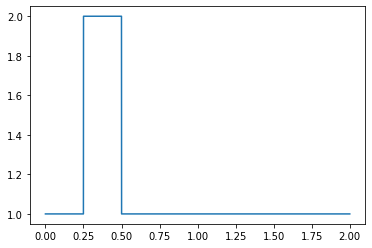

In [101]:
pyplot.plot(numpy.linspace(0, 2, nx), u);

Now it's time to implement the discretization of the convection equation using a finite-difference scheme.  

For every element of our array `u`, we need to perform the operation $u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$

We'll store the result in a new (temporary) array `un`, which will be the solution $u$ for the next time-step.  We will repeat this operation for as many time-steps as we specify and then we can see how far the wave has convected.  

We first initialize our placeholder array `un` to hold the values we calculate for the $n+1$ timestep, using once again the NumPy function `ones()`.

Then, we may think we have two iterative operations: one in space and one in time (we'll learn differently later), so we'll start by nesting one loop inside the other. Note the use of the nifty `range()` function. When we write: `for i in range(1,nx)` we will iterate through the `u` array, but we'll be skipping the first element (the zero-th element).  *Why?*

In [102]:
un = numpy.ones(nx) #initialize a temporary array

for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
    un = u.copy() ##copy the existing values of u into un
    for i in range(1, nx): ## you can try commenting this line and...
    #for i in range(nx): ## ... uncommenting this line and see what happens!
        u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])
        
        

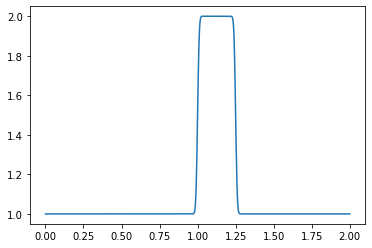

In [103]:
pyplot.plot(numpy.linspace(0, 2, nx), u);